In [4]:
from fdfdpy import Simulation

import sys
sys.path.append("..")

from fdfdpy.optimize.optimization import Optimization
from fdfdpy.optimize.structures import accelerator

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

ModuleNotFoundError: No module named 'adjoint'

In [2]:
# fundamental constants and simulation parameters
c0 = 3e8                     # speed of light in vacuum (m/s)
lambda_m = 2e-6
omega = 2*np.pi*c0/lambda_m  # angular frequency (2pi/s)
dl = 0.5e-1                  # grid size (L0)
NPML = [15, 0]               # number of pml grid points on x and y borders
pol = 'Ez'                   # polarization (either 'Hz' or 'Ez')
num_cells = 5                # number of cells to tile in plots

In [3]:
# material constants
n_index = 1.44               # refractive index
eps_m = n_index**2          # relative permittivity

In [4]:
# geometric parameters
beta = 0.5                  # electron speed / speed of light
gap = 0.4                   # gap size (L0)
lambda0 = lambda_m*1e6      # free space wavelength (L0)
L = 5                       # width of design region (L0)
spc = 2                     # space between PML -> Src. & Src -> Design region

Computed a domain with 278 grids in x and 20 grids in y
The simulation has 40 grids per free space wavelength


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


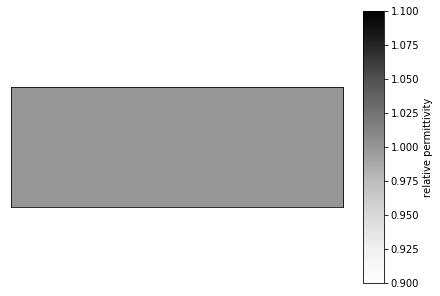

In [5]:
# define permittivity of three port system
eps_r, design_region = accelerator(beta, gap, lambda0, L, spc, dl, NPML, 1)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)                                    # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl)))
simulation.plt_eps(tiled_y=num_cells)
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.src = np.zeros((Nx, Ny))
simulation.src[NPML[0] + int(spc/dl), :] = 1e-9

E0 = 9.448149928859668e-09


/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


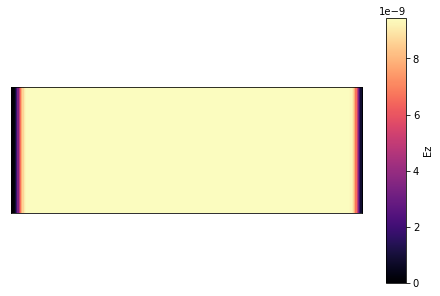

In [7]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True, tiled_y=num_cells)
E0 = np.abs(Ez[nx, ny])
print('E0 = {}'.format(E0))

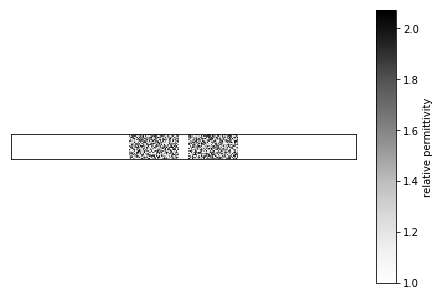

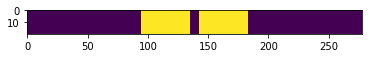

In [8]:
simulation.init_design_region(design_region, eps_m, style='random')
simulation.plt_eps()
plt.show()
plt.imshow(design_region.T)
plt.show()

In [9]:
# define linear and nonlinear parts of objective function + the total objective function form
import autograd.numpy as npa
def J(e, e_nl):
    eta = npa.zeros((Nx, Ny), dtype=npa.complex128)
    eta[nx, :] = 1/Ny*npa.exp(1j*2*npa.pi*dl*npa.linspace(0, Ny-1, Ny)/beta/lambda0)
    return npa.sum(npa.real(e*eta)) / E0

In [19]:
# make optimization object and check derivatives
R = 3   # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta_proj = 1e2
eta= 0.5
simulation.init_design_region(design_region, eps_m, style='random')
optimization = Optimization(J=J, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta_proj, eta=eta)

In [20]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

/Users/twh/autograd/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


adjoint gradient   = [-2.3453622959293218e-05, -5.0316863357676635e-05, -0.00015124679533977918, -0.0001047990606542812, 0.00030630692248254885]
numerical gradient = [-2.3483152715789157e-05, -5.0320777916085246e-05, -0.00015113732347062092, -0.00010503878825930679, 0.0003062642250205999]


In [21]:
# run the optimization with the simulation and the region and nonlinearity information
optimization.J = J
optimization.beta = 1e1
new_eps = optimization.run(method='lbfgs', Nsteps=1000, step_size=2e-1)

/Users/twh/autograd/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")
 ObjectiveFn:  0.067 Iteration:  103/1000 ETA:   0:02:18                       

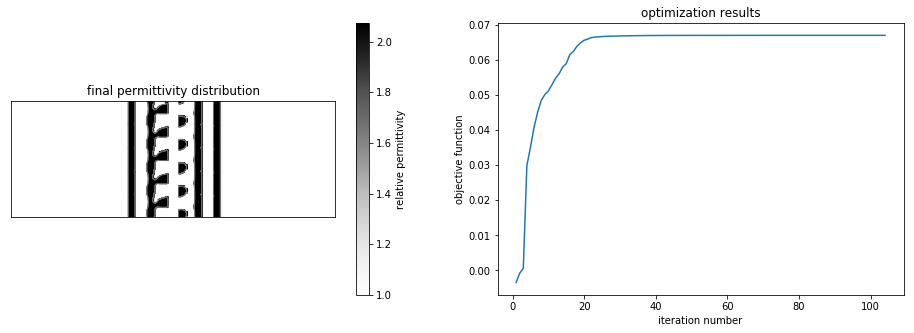

In [22]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1, tiled_y=num_cells, outline=True)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

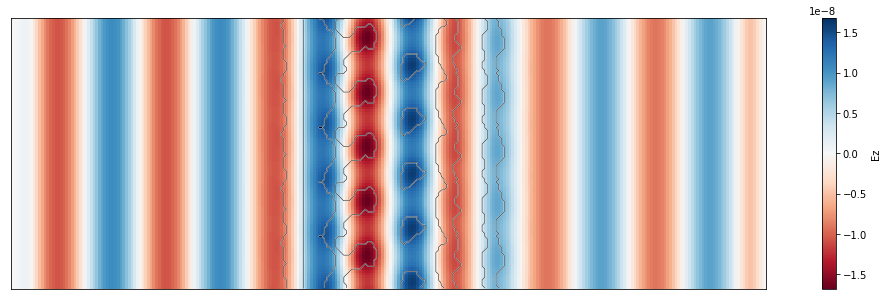

In [14]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax) = plt.subplots(1,1, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_re(ax=ax, tiled_y=num_cells)
ax1.set_title('linear field')

plt.show()

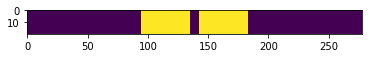

In [15]:
plt.imshow(design_region.T)